In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [7]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### Do updates

In [4]:
update_indexes()

Updated 2020-04-29, max actual date:     2020-04-28


In [6]:
update_stocks()

Updated 2020-04-29, max actual date:     2020-04-28


In [8]:
update_stocks_nc()

Updated 2020-04-29, max actual date:     2020-04-28


In [9]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

no of all available stock: 2395 and indexes: 23


## Single plot

### Plot code

In [87]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [88]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [89]:
papier = 'INTROL'

In [90]:
#plot_paper(papier,'2008-07-15','2008-11-15')

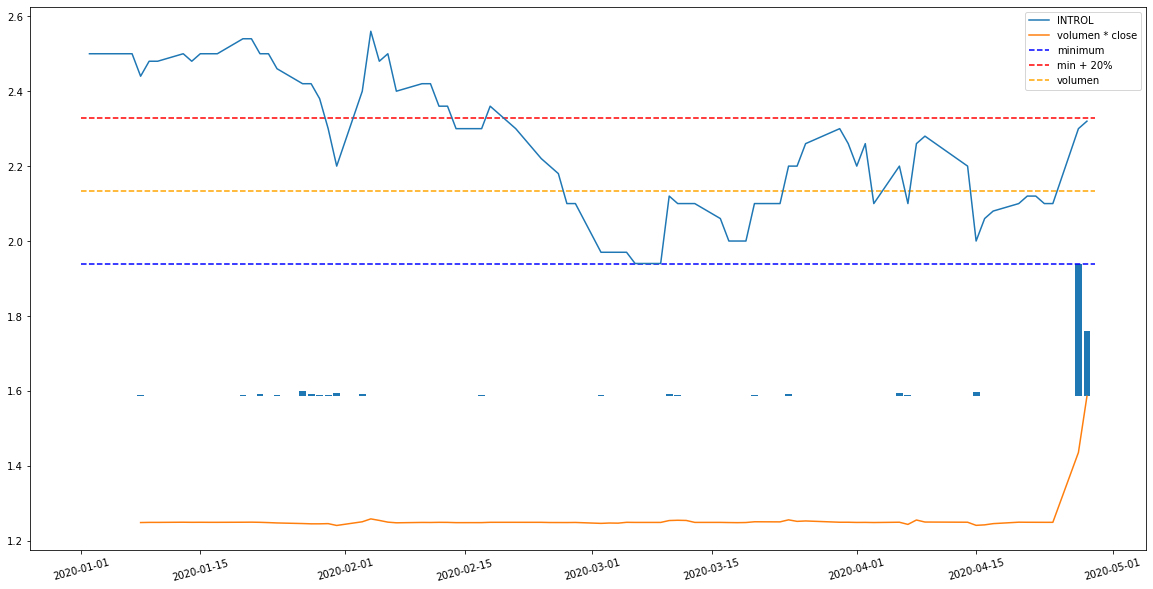

In [91]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [10]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [11]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 2395/2395 [00:22<00:00, 104.30it/s]


In [12]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [13]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 10000)
                              ,:].sort_values('drop_current', ascending=True)

In [14]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [15]:
skaner_df_see.dropna().shape

(252, 15)

In [16]:
skaner_df_see.dropna().head(100)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.2180,2.045583e+04,1.270,2.200,2.6000,0.2180,1.0900,2.200,-42.27,-15.38,400.00,0.00,909.17,-90.09
0,MABION,22.8000,3.379376e+04,51.100,80.000,73.5000,17.9600,31.0000,103.600,-36.12,8.84,72.61,26.95,354.39,-77.99
0,ELBUDOWA,2.0650,1.039129e+05,7.680,6.260,10.1000,1.2000,5.3000,9.240,22.68,-38.02,341.67,72.08,347.46,-77.65
0,ALTUSTFI,0.6400,5.923016e+04,2.190,1.720,2.1500,0.6400,1.2500,2.300,27.33,-20.00,95.31,0.00,259.37,-72.17
0,CCC,38.7000,4.326876e+05,96.500,132.500,153.9000,24.9800,47.0000,133.000,-27.17,-13.91,88.15,54.92,243.67,-70.90
0,BRASTER,0.3465,4.718281e+05,0.370,1.040,1.7300,0.2000,0.4050,1.162,-64.42,-39.88,102.50,73.25,235.35,-70.18
0,SOLAR,3.3000,1.217246e+04,5.800,4.880,5.1500,2.2000,3.6000,10.300,18.85,-5.24,63.64,50.00,212.12,-67.96
0,MOBIMEDIA,0.4000,1.672299e+05,0.725,0.446,0.1290,0.2460,0.4000,1.210,62.56,245.74,62.60,62.60,202.50,-66.94
0,COMECO,0.1350,1.003111e+04,0.200,0.300,0.1600,0.1000,0.1490,0.380,-33.33,87.50,49.00,35.00,181.48,-64.47
0,POZBUD,0.8260,4.299605e+04,1.580,1.910,1.9900,0.6920,1.1900,2.250,-17.28,-4.02,71.97,19.36,172.40,-63.29


## Model

In [17]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

    df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
    df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
    df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [18]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [19]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [20]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 98%|█████████▊| 255/259 [04:41<00:04,  1.11s/it]


In [21]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|█████████▉| 257/258 [00:09<00:00, 25.94it/s]


In [22]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


In [23]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

85

In [24]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:18<00:00,  1.25it/s]


In [25]:
df_indexes_merged.reset_index().head()

,DTYYYYMMDD,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,idxroll80max_chng_VOL,idxroll80std_chng_VOL,idxroll120m_chng_VOL,idxroll120min_chng_VOL,idxroll120max_chng_VOL,idxroll120std_chng_VOL,idxroll240m_chng_VOL,idxroll240min_chng_VOL,idxroll240max_chng_VOL,idxroll240std_chng_VOL
0,1989-10-31,ALL_ORD,1646.3,1646.3,1646.3,1646.3,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-11-01,ALL_ORD,1648.7,1648.7,1648.7,1648.7,0,1646.3,0.145781,1646.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-11-02,ALL_ORD,1652.2,1652.2,1652.2,1652.2,0,1648.7,0.212288,1648.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-11-03,ALL_ORD,1656.9,1656.9,1656.9,1656.9,0,1652.2,0.284469,1652.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-11-06,ALL_ORD,1656.9,1656.9,1656.9,1656.9,0,1656.9,0.000000,1656.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_indexes_merged = df_indexes_merged.reset_index().groupby('DTYYYYMMDD').mean()
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

idx_cols_chng = [c for c in df_indexes_merged.columns if 'chng' in c]

df_indexes_merged = df_indexes_merged.loc[:,idx_cols_chng]

df_indexes_merged = df_indexes_merged.dropna(how = 'all',axis = 1)

In [27]:
# df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
# df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
# df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

In [28]:
#df_merged = df_merged.drop([c for c in df_merged.columns if 'foreign_s' in c], axis = 1).copy()

In [29]:
df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [30]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

#train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [31]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [32]:
valid = df.loc[df.index >= '2020-03-01'].copy()

In [33]:
df = df.loc[df.index < '2020-03-01']

In [34]:
cut_date = '2019-11-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [35]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')
    return model

In [36]:
model = get_model()

In [37]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.7543806	test1: 0.7495309	best: 0.7495309 (0)	total: 413ms	remaining: 1h 8m 45s
1:	test: 0.7644348	test1: 0.7595400	best: 0.7595400 (1)	total: 751ms	remaining: 1h 2m 33s
2:	test: 0.7747869	test1: 0.7705874	best: 0.7705874 (2)	total: 1.12s	remaining: 1h 2m 2s
3:	test: 0.7763523	test1: 0.7710463	best: 0.7710463 (3)	total: 1.45s	remaining: 1h 29s
4:	test: 0.7795112	test1: 0.7711910	best: 0.7711910 (4)	total: 1.82s	remaining: 1h 47s
5:	test: 0.7811711	test1: 0.7707121	best: 0.7711910 (4)	total: 2.17s	remaining: 1h 9s
6:	test: 0.7820888	test1: 0.7708101	best: 0.7711910 (4)	total: 2.52s	remaining: 59m 51s
7:	test: 0.7835954	test1: 0.7729977	best: 0.7729977 (7)	total: 2.88s	remaining: 59m 58s
8:	test: 0.7843798	test1: 0.7746429	best: 0.7746429 (8)	total: 3.21s	remaining: 59m 26s
9:	test: 0.7851046	test1: 0.7754427	best: 0.7754427 (9)	total: 3.55s	remaining: 59m 7s
10:	test: 0.7859156	test1: 0.7761080	best: 0.7761080 (10)	total: 3.9s	remaining: 58m 57s
11:	test: 0.7862258	test1: 0.77

91:	test: 0.7978586	test1: 0.7843356	best: 0.7843508 (90)	total: 36.7s	remaining: 1h 5m 52s
92:	test: 0.7979537	test1: 0.7843416	best: 0.7843508 (90)	total: 37.1s	remaining: 1h 5m 50s
93:	test: 0.7979784	test1: 0.7843473	best: 0.7843508 (90)	total: 37.4s	remaining: 1h 5m 45s
94:	test: 0.7980822	test1: 0.7844350	best: 0.7844350 (94)	total: 37.8s	remaining: 1h 5m 44s
95:	test: 0.7981015	test1: 0.7844316	best: 0.7844350 (94)	total: 38.2s	remaining: 1h 5m 44s
96:	test: 0.7981298	test1: 0.7844284	best: 0.7844350 (94)	total: 38.6s	remaining: 1h 5m 44s
97:	test: 0.7982427	test1: 0.7844749	best: 0.7844749 (97)	total: 39.1s	remaining: 1h 5m 46s
98:	test: 0.7983632	test1: 0.7845297	best: 0.7845297 (98)	total: 39.4s	remaining: 1h 5m 39s
99:	test: 0.7984645	test1: 0.7847374	best: 0.7847374 (99)	total: 39.8s	remaining: 1h 5m 41s
100:	test: 0.7985084	test1: 0.7847860	best: 0.7847860 (100)	total: 40.2s	remaining: 1h 5m 39s
101:	test: 0.7985741	test1: 0.7849521	best: 0.7849521 (101)	total: 40.6s	remai

179:	test: 0.8024961	test1: 0.7868871	best: 0.7868871 (179)	total: 1m 11s	remaining: 1h 4m 52s
180:	test: 0.8025436	test1: 0.7869107	best: 0.7869107 (180)	total: 1m 11s	remaining: 1h 4m 52s
181:	test: 0.8026302	test1: 0.7869669	best: 0.7869669 (181)	total: 1m 12s	remaining: 1h 4m 55s
182:	test: 0.8026675	test1: 0.7869587	best: 0.7869669 (181)	total: 1m 12s	remaining: 1h 4m 59s
183:	test: 0.8027412	test1: 0.7869479	best: 0.7869669 (181)	total: 1m 13s	remaining: 1h 4m 57s
184:	test: 0.8027756	test1: 0.7869626	best: 0.7869669 (181)	total: 1m 13s	remaining: 1h 4m 55s
185:	test: 0.8028112	test1: 0.7869581	best: 0.7869669 (181)	total: 1m 13s	remaining: 1h 4m 53s
186:	test: 0.8028488	test1: 0.7869584	best: 0.7869669 (181)	total: 1m 14s	remaining: 1h 4m 51s
187:	test: 0.8028587	test1: 0.7869631	best: 0.7869669 (181)	total: 1m 14s	remaining: 1h 4m 50s
188:	test: 0.8029061	test1: 0.7870117	best: 0.7870117 (188)	total: 1m 14s	remaining: 1h 4m 50s
189:	test: 0.8029403	test1: 0.7870578	best: 0.7870

266:	test: 0.8056693	test1: 0.7876588	best: 0.7876845 (265)	total: 1m 45s	remaining: 1h 4m 9s
267:	test: 0.8056862	test1: 0.7876558	best: 0.7876845 (265)	total: 1m 45s	remaining: 1h 4m 8s
268:	test: 0.8057021	test1: 0.7876630	best: 0.7876845 (265)	total: 1m 46s	remaining: 1h 4m 7s
269:	test: 0.8057384	test1: 0.7876083	best: 0.7876845 (265)	total: 1m 46s	remaining: 1h 4m 7s
270:	test: 0.8058104	test1: 0.7876150	best: 0.7876845 (265)	total: 1m 47s	remaining: 1h 4m 8s
271:	test: 0.8058256	test1: 0.7876057	best: 0.7876845 (265)	total: 1m 47s	remaining: 1h 4m 6s
272:	test: 0.8058412	test1: 0.7876011	best: 0.7876845 (265)	total: 1m 47s	remaining: 1h 4m 5s
273:	test: 0.8058637	test1: 0.7876056	best: 0.7876845 (265)	total: 1m 48s	remaining: 1h 4m 5s
274:	test: 0.8058934	test1: 0.7876760	best: 0.7876845 (265)	total: 1m 48s	remaining: 1h 4m 5s
275:	test: 0.8059032	test1: 0.7876556	best: 0.7876845 (265)	total: 1m 49s	remaining: 1h 4m 4s
276:	test: 0.8059234	test1: 0.7876111	best: 0.7876845 (265)	

353:	test: 0.8083355	test1: 0.7876535	best: 0.7876845 (265)	total: 2m 20s	remaining: 1h 3m 38s
354:	test: 0.8083769	test1: 0.7876192	best: 0.7876845 (265)	total: 2m 20s	remaining: 1h 3m 37s
355:	test: 0.8084140	test1: 0.7876185	best: 0.7876845 (265)	total: 2m 20s	remaining: 1h 3m 36s
356:	test: 0.8084210	test1: 0.7876095	best: 0.7876845 (265)	total: 2m 21s	remaining: 1h 3m 35s
357:	test: 0.8084447	test1: 0.7876261	best: 0.7876845 (265)	total: 2m 21s	remaining: 1h 3m 34s
358:	test: 0.8084631	test1: 0.7876662	best: 0.7876845 (265)	total: 2m 22s	remaining: 1h 3m 34s
359:	test: 0.8084988	test1: 0.7876662	best: 0.7876845 (265)	total: 2m 22s	remaining: 1h 3m 31s
360:	test: 0.8085191	test1: 0.7877155	best: 0.7877155 (360)	total: 2m 22s	remaining: 1h 3m 31s
361:	test: 0.8085283	test1: 0.7877221	best: 0.7877221 (361)	total: 2m 23s	remaining: 1h 3m 30s
362:	test: 0.8086011	test1: 0.7877353	best: 0.7877353 (362)	total: 2m 23s	remaining: 1h 3m 30s
363:	test: 0.8086730	test1: 0.7878661	best: 0.7878

440:	test: 0.8105887	test1: 0.7878190	best: 0.7879887 (369)	total: 2m 54s	remaining: 1h 3m 1s
441:	test: 0.8106047	test1: 0.7877847	best: 0.7879887 (369)	total: 2m 54s	remaining: 1h 3m 2s
442:	test: 0.8106413	test1: 0.7877841	best: 0.7879887 (369)	total: 2m 55s	remaining: 1h 3m 2s
443:	test: 0.8106600	test1: 0.7878252	best: 0.7879887 (369)	total: 2m 55s	remaining: 1h 3m 2s
444:	test: 0.8106727	test1: 0.7878157	best: 0.7879887 (369)	total: 2m 56s	remaining: 1h 3m 3s
445:	test: 0.8106868	test1: 0.7878091	best: 0.7879887 (369)	total: 2m 56s	remaining: 1h 3m 2s
446:	test: 0.8107196	test1: 0.7878091	best: 0.7879887 (369)	total: 2m 56s	remaining: 1h 3m 2s
447:	test: 0.8107277	test1: 0.7877993	best: 0.7879887 (369)	total: 2m 57s	remaining: 1h 3m 1s
448:	test: 0.8107349	test1: 0.7878221	best: 0.7879887 (369)	total: 2m 57s	remaining: 1h 2m 59s
449:	test: 0.8107447	test1: 0.7878096	best: 0.7879887 (369)	total: 2m 58s	remaining: 1h 2m 59s
450:	test: 0.8107548	test1: 0.7878156	best: 0.7879887 (369

In [38]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll240std_chng_HIGH,12.227512
1,roll80std_chng_OPEN,4.507939
2,roll120std_chng_HIGH,4.451298
3,roll120std_move_strength,4.152686
4,roll80max_chng_LOW,3.437390
5,roll40std_chng_HIGH,3.400210
6,roll80std_chng_HIGH,2.736072
7,roll120std_chng_LOW,2.717487
8,roll240std_chng_LOW,2.714244
9,roll120std_diff_LOW_HIGH,2.062280


In [39]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

408

### Check performance

In [40]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [46]:
preds = preds_proba[:,1].copy()

preds[preds > 0.6] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [47]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[15532,     2],
       [ 2152,    13]])

In [48]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(15532, 2, 2152, 13)

In [49]:
(tn + tp) / (tn + tp + fp + fn)

0.8782982089383581

In [50]:
tp / (tp + fp)

0.8666666666666667

In [51]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.895650,0.104350
1.0,0.765278,0.234722


In [52]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

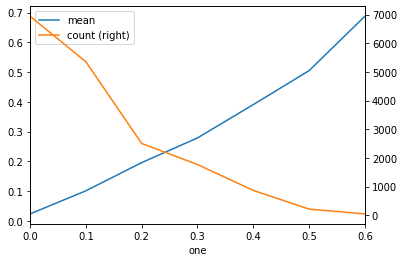

In [53]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [54]:
df_res_grouped

,mean,count
one,,
0.0,0.023199,6940
0.1,0.100878,5353
0.2,0.195609,2505
0.3,0.278531,1770
0.4,0.390553,868
0.5,0.504630,216
0.6,0.687500,48


#### Check valid

In [55]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [56]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [57]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[6008,   58],
       [1876,  103]])

In [58]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(6008, 58, 1876, 103)

In [59]:
(tn + tp) / (tn + tp + fp + fn)

0.7596022374145432

In [60]:
tp / (tp + fp)

0.639751552795031

### Prediction

In [62]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [63]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [64]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 99%|█████████▉| 249/252 [05:01<00:03,  1.21s/it]


In [65]:
qtransformed.qsize()

252

In [66]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 252/252 [00:00<00:00, 683.39it/s]


In [67]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [68]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [69]:
res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False).tail(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
2336,2020-04-20,CFI,0.2850,0.270,0.2850,0.2840,0.284,0.2680,0.285,0.2790,3.521127e-01,-1.760563,0.000000e+00,0.000000,-0.740741,-5.281690,-1.760563,NaN,NaN,0.171511
3059,2020-04-20,URSUS,0.5700,0.550,0.5730,0.5640,0.564,0.5360,0.564,0.5460,0.000000e+00,-3.191489,0.000000e+00,-1.570681,-2.545455,-4.255319,-2.482270,NaN,NaN,0.171380
2083,2020-04-20,MEDICALG,24.9000,22.850,24.9000,24.5000,24.500,22.5500,24.900,23.6500,1.632653e+00,-3.469388,0.000000e+00,0.000000,-1.312910,-2.857143,-2.040816,NaN,NaN,0.170508
6104,2020-04-20,SYGNITY,3.0100,2.860,3.0100,2.9700,2.960,2.7300,2.960,2.8800,0.000000e+00,-2.702703,-3.367003e-01,-1.661130,-4.545455,2.702703,2.702703,NaN,NaN,0.169564
5694,2020-04-20,BBIDEV,3.4400,3.430,3.4900,3.4300,3.400,3.2700,3.400,3.2800,0.000000e+00,-3.529412,-8.746356e-01,-2.578797,-4.664723,-4.117647,-0.294118,NaN,NaN,0.169181
1400,2020-04-20,TORPOL,7.7800,7.620,7.9600,7.7400,7.660,7.0400,7.660,7.3400,0.000000e+00,-4.177546,-1.033592e+00,-3.768844,-7.611549,0.000000,0.522193,NaN,NaN,0.168958
2607,2020-04-20,PGE,4.4800,4.338,4.5080,4.3980,4.382,4.0700,4.400,4.1000,4.107713e-01,-6.435418,-3.638017e-01,-2.395741,-6.177962,-8.032862,-3.035144,NaN,NaN,0.168497
6687,2020-04-20,MBANK,220.0000,209.000,222.0000,217.6000,218.000,208.0000,218.000,208.0000,0.000000e+00,-4.587156,1.838235e-01,-1.801802,-0.478469,-7.155963,0.458716,NaN,NaN,0.165701
6584,2020-04-20,SANPL,157.0000,154.100,160.3000,158.7000,156.500,151.9000,158.100,152.0000,1.022364e+00,-2.875399,-1.386263e+00,-1.372427,-1.427644,-7.220447,-2.236422,NaN,NaN,0.164349
2950,2020-04-20,GRUPAAZOTY,27.8000,25.550,27.8000,26.4000,26.400,25.1000,26.400,26.2000,0.000000e+00,-0.757576,0.000000e+00,-5.035971,-1.761252,-0.189394,0.946970,NaN,NaN,0.164136


In [71]:
res.loc[res.DTYYYYMMDD == '2020-04-28'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
1781,2020-04-28,ITMTRADE,0.2180,0.2010,0.2500,0.2180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443887
1150,2020-04-28,IGORIA,0.1890,0.1600,0.1890,0.1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424237
847,2020-04-28,JWA,0.2000,0.2000,0.2280,0.2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.399994
1399,2020-04-28,FABRYKAKD,0.1110,0.1110,0.1110,0.1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384825
1541,2020-04-28,NFPL,0.3000,0.2500,0.3000,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383882
1864,2020-04-28,MBFGROUP,6.5000,5.3500,6.5000,5.5500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.370877
1356,2020-04-28,PARCELTEC,0.5600,0.5000,0.7960,0.7960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361906
1789,2020-04-28,PARTNER,0.0580,0.0580,0.0750,0.0750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359877
1489,2020-04-28,MERLINGRP,0.3980,0.2500,0.3980,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359355
297,2020-04-28,ECCGAMES,4.0100,3.9200,4.1500,4.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.358300


In [74]:
last_day = res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False)

In [86]:
res.TICKER.apply(lambda x: True if 'INTROL' in x else False).sum()

0

In [75]:
last_day.mean()

OPEN                   835.259164
LOW                    825.076042
HIGH                   842.923726
CLOSE                  840.031098
fut_OPEN               836.597488
fut_LOW                809.485620
fut_HIGH               838.324321
fut_CLOSE              813.803424
fOPEN_fHIGH_chng         1.407228
fOPEN_fCLOSE_chng       -3.597238
CLOSE_fOPEN_chng        -0.039052
HIGH_fHIGH_chng         -1.586532
LOW_fLOW_chng           -2.984150
fOPEN_f5CLOSE_chng      -0.093398
fOPEN_f5MAX_chng         3.210729
fOPEN_f10CLOSE_chng           NaN
fOPEN_f10MAX_chng             NaN
pred_prob                0.206406
dtype: float64

In [76]:
last_day.loc[last_day.pred_prob > 0.5].mean()

OPEN                    0.093750
LOW                     0.078750
HIGH                    0.093750
CLOSE                   0.078750
fut_OPEN                0.083500
fut_LOW                 0.083250
fut_HIGH                0.084000
fut_CLOSE               0.083750
fOPEN_fHIGH_chng        0.454545
fOPEN_fCLOSE_chng       0.015949
CLOSE_fOPEN_chng        4.565217
HIGH_fHIGH_chng        -7.742475
LOW_fLOW_chng           4.130435
fOPEN_f5CLOSE_chng     11.244019
fOPEN_f5MAX_chng       28.516746
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.529944
dtype: float64

In [78]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    0.886230
LOW                     0.792219
HIGH                    0.908398
CLOSE                   0.819512
fut_OPEN                0.833715
fut_LOW                 0.790513
fut_HIGH                0.914659
fut_CLOSE               0.869879
fOPEN_fHIGH_chng        6.434910
fOPEN_fCLOSE_chng       2.987126
CLOSE_fOPEN_chng       -0.346951
HIGH_fHIGH_chng        -1.258526
LOW_fLOW_chng          -2.064195
fOPEN_f5CLOSE_chng     21.797487
fOPEN_f5MAX_chng       32.199004
fOPEN_f10CLOSE_chng    44.750507
fOPEN_f10MAX_chng      62.453547
pred_prob               0.555840
dtype: float64

In [79]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

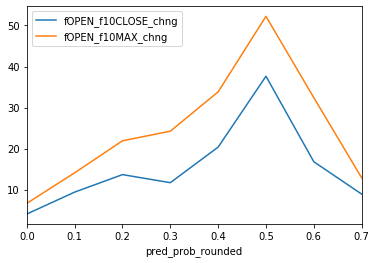

In [80]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']].plot()

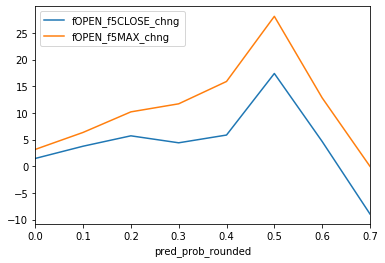

In [81]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng']].plot()

In [82]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']]

,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng
pred_prob_rounded,,
0.0,4.074572,6.675369
0.1,9.407500,14.110776
0.2,13.669781,21.909909
0.3,11.705661,24.244972
0.4,20.366856,33.822122
0.5,37.630188,52.218663
0.6,16.807221,32.411777
0.7,8.927739,12.897436


In [83]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng']]

,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng
pred_prob_rounded,,
0.0,1.483310,3.177432
0.1,3.777353,6.360534
0.2,5.727187,10.216209
0.3,4.419246,11.727169
0.4,5.873120,15.914889
0.5,17.409593,28.122321
0.6,4.665250,12.841677
0.7,-8.927739,0.000000


## Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
